In [90]:
import requests
import json
import pandas as pd

In [ ]:
# The ENDPOINT should be like: https://mvad-sample.cognitiveservices.azure.com/anomalydetector/v1.1
ENDPOINT = "{Your endpoint of Anomaly Detector resource}anomalydetector/v1.1"
HEADERS = {
    "Ocp-Apim-Subscription-Key": "{Your key of Anomaly Detector resource.}"
}
# The data source url should be like: https://mvaddataset.blob.core.windows.net/sample-multitable/sample_data_5_300
DATA_SOURCE_URL= "{The Blob URL for your data.}"
# If your data is one CSV file, please set the dataSchema as `OneTable`, if your data is multiple CSV files in a folder, please set the dataSchema as `MultiTable`.
DATA_SCHEMA="{Please specify your dataSchema as 'MultiTable' or 'OneTable'.}"

In [91]:
ENDPOINT = "https://mvad-ga-1028.cognitiveservices.azure.com/anomalydetector/v1.1"
HEADERS = {
    "Ocp-Apim-Subscription-Key": "----"
}
DATA_SOURCE_URL= "https://mvaddata1.blob.core.windows.net/mvad/sample_data_5_3000.csv"
DATA_SCHEMA="OneTable"

In [92]:
API_MODEL = "{endpoint}/multivariate/models"
API_MODEL_STATUS = "{endpoint}/multivariate/models/{model_id}"
API_MODEL_BATCH_INFERENCE = "{endpoint}/multivariate/models/{model_id}:detect-batch"
API_MODEL_LAST_INFERENCE = "{endpoint}/multivariate/models/{model_id}:detect-last"
API_RESULTS = "{endpoint}/multivariate/detect-batch/{result_id}"
API_DELETE = "{endpoint}/multivariate/models/{model_id}"

# Train a model

In [109]:
SLIDING_WINDOW = 200
data = {
    "slidingWindow": SLIDING_WINDOW,
    "alignPolicy": {
        "alignMode": "Outer",
        "fillNAMethod": "Linear", 
        "paddingValue": 0
    },
    "dataSource": DATA_SOURCE_URL,
    "dataSchema": DATA_SCHEMA,
    "startTime": "2021-01-01T00:00:00Z", 
    "endTime": "2021-01-02T09:19:00Z", 
    "displayName": "SampleRequest"
}

res = requests.post(API_MODEL.format(endpoint=ENDPOINT), data=json.dumps(data), headers=HEADERS)
assert res.status_code == 201, f"Error occurred. Error message: {res.content}"
print(res.content)
location = res.headers['Location']
model_id = location[location.rindex('/')+1:]
print(f"ModelId is {model_id}")

b'{"modelId": "e4023bd6-56c1-11ed-8c9b-3a0e6104b5f6", "createdTime": "2022-10-28T13:10:27Z", "lastUpdatedTime": "2022-10-28T13:10:27Z", "modelInfo": {"dataSource": "https://mvaddata1.blob.core.windows.net/mvad/sample_data_5_3000.csv", "dataSchema": "OneTable", "startTime": "2021-01-01T00:00:00Z", "endTime": "2021-01-02T09:19:00Z", "displayName": "SampleRequest", "slidingWindow": 200, "alignPolicy": {"alignMode": "Outer", "fillNAMethod": "Linear", "paddingValue": 0.0}, "status": "CREATED", "errors": [], "diagnosticsInfo": {"modelState": {"epochIds": [], "trainLosses": [], "validationLosses": [], "latenciesInSeconds": []}, "variableStates": []}}}\n'
ModelId is e4023bd6-56c1-11ed-8c9b-3a0e6104b5f6


# Get model status

In [113]:
res = requests.get(API_MODEL_STATUS.format(endpoint=ENDPOINT, model_id = model_id), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
res_content = json.loads(res.content)
# res_content
# print(json.dumps(res_content))
print(f"Model is {res_content['modelInfo']['status']}")

Model is READY


# Asynchronous Inference

## Trigger asynchronous inference

In [112]:
data = {
    "dataSource": DATA_SOURCE_URL,
    "topContributorCount": 10,
    "startTime": "2021-01-02T12:00:00Z", 
    "endTime": "2021-01-03T00:00:00Z"
}

res = requests.post(API_MODEL_BATCH_INFERENCE.format(endpoint=ENDPOINT, model_id=model_id), 
                    data=json.dumps(data), headers=HEADERS)

print(res.headers)
print(res.content)
assert res.status_code == 202, f"Error occurred. Error message: {res.content}"
result_id = res.headers["operation-id"]
print(f"Result id is {result_id}")

{'Content-Length': '337', 'Content-Type': 'application/json', 'operation-location': 'https://mvad-ga-1028.cognitiveservices.azure.com:443/anomalydetector/v1.1/multivariate/detect-batch/', 'operation-id': '255c1da4-56c2-11ed-afed-3a0e6104b5f6', 'x-envoy-upstream-service-time': '163', 'apim-request-id': 'cda3919e-8de5-4dce-a1b0-c271b3e876f5', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff', 'x-ms-region': 'UK South', 'Date': 'Fri, 28 Oct 2022 13:12:16 GMT'}
b'{"resultId": "255c1da4-56c2-11ed-afed-3a0e6104b5f6", "summary": {"status": "CREATED", "errors": [], "variableStates": [], "setupInfo": {"dataSource": "https://mvaddata1.blob.core.windows.net/mvad/sample_data_5_3000.csv", "topContributorCount": 10, "startTime": "2021-01-02T12:00:00Z", "endTime": "2021-01-03T00:00:00Z"}}, "results": []}\n'
result id is 255c1da4-56c2-11ed-afed-3a0e6104b5f6


## Get batch inference results

In [114]:
res = requests.get(API_RESULTS.format(endpoint=ENDPOINT, result_id=result_id), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
batch_results=json.loads(res.content)
batch_results

{'resultId': '255c1da4-56c2-11ed-afed-3a0e6104b5f6',
 'summary': {'status': 'READY',
  'errors': [],
  'variableStates': [{'variable': 'series_0',
    'filledNARatio': 0.0,
    'effectiveCount': 721,
    'firstTimestamp': '2021-01-02T12:00:00Z',
    'lastTimestamp': '2021-01-03T00:00:00Z'},
   {'variable': 'series_1',
    'filledNARatio': 0.0,
    'effectiveCount': 721,
    'firstTimestamp': '2021-01-02T12:00:00Z',
    'lastTimestamp': '2021-01-03T00:00:00Z'},
   {'variable': 'series_2',
    'filledNARatio': 0.0,
    'effectiveCount': 721,
    'firstTimestamp': '2021-01-02T12:00:00Z',
    'lastTimestamp': '2021-01-03T00:00:00Z'},
   {'variable': 'series_3',
    'filledNARatio': 0.0,
    'effectiveCount': 721,
    'firstTimestamp': '2021-01-02T12:00:00Z',
    'lastTimestamp': '2021-01-03T00:00:00Z'},
   {'variable': 'series_4',
    'filledNARatio': 0.0,
    'effectiveCount': 721,
    'firstTimestamp': '2021-01-02T12:00:00Z',
    'lastTimestamp': '2021-01-03T00:00:00Z'}],
  'setupInfo': 

In [115]:
batch_results_df=pd.json_normalize(batch_results,record_path=['results'])
batch_results_df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation
0,2021-01-02T12:00:00Z,[],False,0.000000,0.337481,[]
1,2021-01-02T12:01:00Z,[],False,0.000000,0.238778,[]
2,2021-01-02T12:02:00Z,[],False,0.000000,0.163547,[]
3,2021-01-02T12:03:00Z,[],False,0.000000,0.237346,[]
4,2021-01-02T12:04:00Z,[],False,0.000000,0.245659,[]
...,...,...,...,...,...,...
716,2021-01-02T23:56:00Z,[],False,0.000000,0.249437,[]
717,2021-01-02T23:57:00Z,[],False,0.000000,0.342212,[]
718,2021-01-02T23:58:00Z,[],True,0.299054,0.513859,"[{'variable': 'series_1', 'contributionScore':..."
719,2021-01-02T23:59:00Z,[],False,0.000000,0.448912,[]


# Streaming Inference

In [117]:
import json

with open("5_3000.json", "r") as f:
    sample_input = json.load(f)

url = API_MODEL_LAST_INFERENCE.format(endpoint=ENDPOINT,model_id=model_id)
payload = sample_input

res = requests.post(url, headers=HEADERS, data=json.dumps(payload))
# print(res.content)
streaming_results=json.loads(res.content)
streaming_results

{'variableStates': [{'variable': 'series_0',
   'filledNARatio': 0.0,
   'effectiveCount': 1,
   'firstTimestamp': '2021-01-03T01:59:00Z',
   'lastTimestamp': '2021-01-03T01:59:00Z'},
  {'variable': 'series_1',
   'filledNARatio': 0.0,
   'effectiveCount': 1,
   'firstTimestamp': '2021-01-03T01:59:00Z',
   'lastTimestamp': '2021-01-03T01:59:00Z'},
  {'variable': 'series_2',
   'filledNARatio': 0.0,
   'effectiveCount': 1,
   'firstTimestamp': '2021-01-03T01:59:00Z',
   'lastTimestamp': '2021-01-03T01:59:00Z'},
  {'variable': 'series_3',
   'filledNARatio': 0.0,
   'effectiveCount': 1,
   'firstTimestamp': '2021-01-03T01:59:00Z',
   'lastTimestamp': '2021-01-03T01:59:00Z'},
  {'variable': 'series_4',
   'filledNARatio': 0.0,
   'effectiveCount': 1,
   'firstTimestamp': '2021-01-03T01:59:00Z',
   'lastTimestamp': '2021-01-03T01:59:00Z'}],
 'results': [{'timestamp': '2021-01-03T01:59:00Z',
   'value': {'isAnomaly': False,
    'severity': 0.0,
    'score': 0.2724536955356598,
    'interpre

In [118]:
streaming_results_df=pd.json_normalize(streaming_results,record_path=['results'])
streaming_results_df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation
0,2021-01-03T01:59:00Z,[],False,0.0,0.272454,[]


# List models

In [119]:
res = requests.get(API_MODEL.format(endpoint=ENDPOINT), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
# print(res.content)

model_list = json.loads(res.content)
model_list

{'models': [{'modelId': 'e4023bd6-56c1-11ed-8c9b-3a0e6104b5f6',
   'createdTime': '2022-10-28T13:10:27Z',
   'lastUpdatedTime': '2022-10-28T13:11:29Z',
   'modelInfo': {'dataSource': 'https://mvaddata1.blob.core.windows.net/mvad/sample_data_5_3000.csv',
    'dataSchema': 'OneTable',
    'startTime': '2021-01-01T00:00:00Z',
    'endTime': '2021-01-02T09:19:00Z',
    'displayName': 'SampleRequest',
    'slidingWindow': 200,
    'alignPolicy': {'alignMode': 'Outer',
     'fillNAMethod': 'Linear',
     'paddingValue': 0.0},
    'status': 'READY',
    'errors': [],
    'diagnosticsInfo': {'modelState': {'epochIds': [10,
       20,
       30,
       40,
       50,
       60,
       70,
       80,
       90,
       100],
      'trainLosses': [0.42961672395467754,
       0.3063986077904701,
       0.2618359178304672,
       0.24399512410163882,
       0.23450686335563659,
       0.22792436480522155,
       0.22304908633232118,
       0.22581463456153872,
       0.22068361043930054,
       0.40

In [120]:
model_list=pd.json_normalize(model_list,record_path=['models'],meta=['currentCount','maxCount'])
model_list= df[['modelId','modelInfo.displayName','modelInfo.status','modelInfo.dataSource','currentCount','maxCount']]
model_list

,modelId,modelInfo.displayName,modelInfo.status,modelInfo.dataSource,currentCount,maxCount
0,1c2222de-56a8-11ed-afed-3a0e6104b5f6,SampleRequest,READY,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
1,5d0f1b78-56a6-11ed-afed-3a0e6104b5f6,SampleRequest,READY,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
2,3d22b854-5694-11ed-abc8-b679c3d429e0,SampleRequest,READY,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
3,2828ad1e-5694-11ed-9449-9e7261b759c5,SampleRequest,FAILED,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
4,dd1dc7d2-5693-11ed-a773-86cdb0bfc0fd,SampleRequest,FAILED,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
5,b2805f8a-5693-11ed-a773-86cdb0bfc0fd,SampleRequest,FAILED,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000
6,88f1780c-5693-11ed-83aa-b679c3d429e0,SampleRequest,FAILED,https://mvaddata1.blob.core.windows.net/mvad/s...,7,1000


# Delete model

In [ ]:
res = requests.delete(API_DELETE.format(endpoint=ENDPOINT, model_id=model_id), headers=HEADERS)
assert res.status_code == 204, f"Error occurred. Error message: {res.content}"
print(res.content)

In [121]:
import seaborn as sns
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [122]:
tips = sns.load_dataset("tips")

In [124]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<AxesSubplot:xlabel='tip', ylabel='total_bill'>

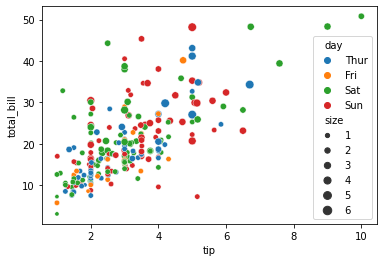

In [130]:
sns.scatterplot(x="tip",y="total_bill",data=tips,hue="day",size="size")

In [131]:
batch_results_df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation
0,2021-01-02T12:00:00Z,[],False,0.000000,0.337481,[]
1,2021-01-02T12:01:00Z,[],False,0.000000,0.238778,[]
2,2021-01-02T12:02:00Z,[],False,0.000000,0.163547,[]
3,2021-01-02T12:03:00Z,[],False,0.000000,0.237346,[]
4,2021-01-02T12:04:00Z,[],False,0.000000,0.245659,[]
...,...,...,...,...,...,...
716,2021-01-02T23:56:00Z,[],False,0.000000,0.249437,[]
717,2021-01-02T23:57:00Z,[],False,0.000000,0.342212,[]
718,2021-01-02T23:58:00Z,[],True,0.299054,0.513859,"[{'variable': 'series_1', 'contributionScore':..."
719,2021-01-02T23:59:00Z,[],False,0.000000,0.448912,[]


<AxesSubplot:xlabel='timestamp', ylabel='value.score'>

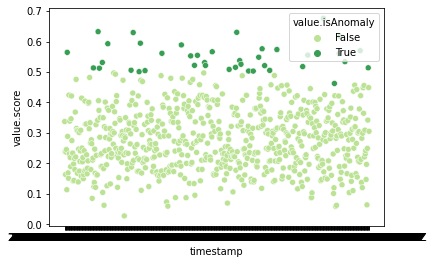

In [134]:
sns.scatterplot(x="timestamp",y="value.score",data=batch_results_df,hue="value.isAnomaly",palette="YlGn")

In [142]:
data=pd.read_csv('sample_data_5_3000.csv')
data

,timestamp,series_0,series_1,series_2,series_3,series_4
0,2021-01-01T00:00:00Z,-0.029423,-0.473649,-0.192245,1.346951,1.289716
1,2021-01-01T00:01:00Z,1.007787,-1.052367,0.262377,-0.143764,0.535112
2,2021-01-01T00:02:00Z,-0.748066,-0.566473,-0.072228,2.098236,-0.680700
3,2021-01-01T00:03:00Z,0.969546,-0.376076,0.190655,-0.481221,0.512042
4,2021-01-01T00:04:00Z,-1.437885,0.882075,-1.007225,-1.061802,0.575166
...,...,...,...,...,...,...
2995,2021-01-03T01:55:00Z,0.572729,-1.318392,0.492164,-0.326105,-0.494300
2996,2021-01-03T01:56:00Z,1.311772,0.408282,0.278034,0.505975,0.494727
2997,2021-01-03T01:57:00Z,1.079186,0.528480,0.066745,-1.186922,0.836286
2998,2021-01-03T01:58:00Z,0.138812,0.657773,-0.456893,0.339240,-0.647699


In [149]:
df=pd.merge(batch_results_df,data, on="timestamp")
df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation,series_0,series_1,series_2,series_3,series_4
0,2021-01-02T12:00:00Z,[],False,0.000000,0.337481,[],1.406643,0.038892,-0.900322,-0.496920,1.835452
1,2021-01-02T12:01:00Z,[],False,0.000000,0.238778,[],0.498293,-1.203895,-0.015028,0.639817,1.336381
2,2021-01-02T12:02:00Z,[],False,0.000000,0.163547,[],0.482624,0.117251,-0.346558,0.380744,1.216002
3,2021-01-02T12:03:00Z,[],False,0.000000,0.237346,[],0.135886,0.175647,0.529109,-1.525938,-0.921328
4,2021-01-02T12:04:00Z,[],False,0.000000,0.245659,[],-1.056639,-1.452493,-0.204444,-0.408568,-0.532862
...,...,...,...,...,...,...,...,...,...,...,...
716,2021-01-02T23:56:00Z,[],False,0.000000,0.249437,[],-0.496276,-0.327522,-0.982608,-1.152828,0.732866
717,2021-01-02T23:57:00Z,[],False,0.000000,0.342212,[],0.833020,0.285757,-1.691492,-1.481046,0.214137
718,2021-01-02T23:58:00Z,[],True,0.299054,0.513859,"[{'variable': 'series_1', 'contributionScore':...",0.864732,2.680365,1.244429,0.827081,-1.171265
719,2021-01-02T23:59:00Z,[],False,0.000000,0.448912,[],-0.742697,-1.620215,-1.778069,-1.627223,0.172657


<AxesSubplot:xlabel='timestamp', ylabel='value.score'>

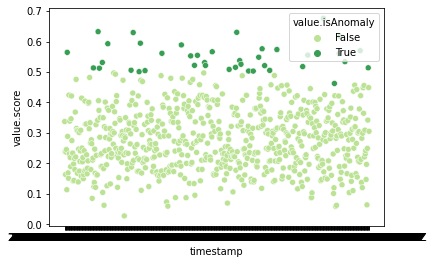

In [150]:
sns.scatterplot(x="timestamp",y="value.score",data=df,hue="value.isAnomaly",palette="YlGn")